In [1]:
from sentinelhub import SHConfig
import numpy as np
from pyproj import Proj, transform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from pyproj import Transformer
import dateutil.parser
import pickle
from calendar import monthrange
import datetime
import cartopy.crs as ccrs
import cartopy
import sentinelhub
from sentinelhub import geo_utils
import matplotlib.pyplot as plt

from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest

from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, DataCollection


In [2]:
config = SHConfig()

In [3]:
sh_details = pickle.load(open('/home/robbie/Dropbox/beaufort_sea/sar/sh_details.p','rb'))

config.instance_id = sh_details['instance_id']
config.sh_client_id = sh_details['client_id']
config.sh_client_secret = sh_details['client_secret']
config.save()

In [4]:
lon0 = -40
lat0 = 75
lon1 = -5
lat1 = 84

GD_CRS = ccrs.PlateCarree()
PC_CRS = ccrs.UTM(zone=28)

x0, y0 = PC_CRS.transform_point(lon0, lat0, GD_CRS)
x1, y1 = PC_CRS.transform_point(lon1, lat1, GD_CRS)

In [5]:
# bbox = BBox([lon0, lat0, lon1, lat1],crs=CRS.WGS84)

bbox = BBox([x0, y0, x1, y1],crs=CRS.UTM_28N)

bbox_size = bbox_to_dimensions(bbox,resolution=1000)

time_interval = ('2021-02-22', '2021-02-23')

evalscript_all_bands = """
 //VERSION=3

function evaluatePixel(sample) {
    return [sample.HH, sample.HV, sample.dataMask];
}

function setup() {
  return {
    input: [{
      bands: [
        "HH",
        "HV",
        "dataMask"
      ]
    }],
    output: {
      bands: 3,
      sampleType:"FLOAT32"
    }
  }
}
"""

request_all_bands = SentinelHubRequest(
#     data_folder='/home/robbie/Dropbox/beaufort_sea/sar',
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL1_EW,
            time_interval=time_interval,
    )],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=bbox,
    size=bbox_size,
    config=config
)

data = request_all_bands.get_data()

In [6]:
HH = data[0][:,:,0]

HV = data[0][:,:,1]

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


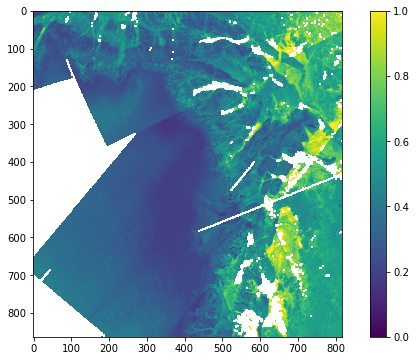

In [7]:
plt.figure(figsize=(10,6))
plt.imshow(np.log(np.divide(HH,HV))/np.log(100),vmin=0,vmax=1)
plt.colorbar()


dtp = np.log(np.divide(HH,HV))/np.log(100)

In [8]:
bb_utm = sentinelhub.geo_utils.to_utm_bbox(bbox)
transf = bb_utm.get_transform_vector(resx=1000, resy=1000)

pix_row = np.arange(0, bbox_size[1])
rows = np.array([pix_row] * bbox_size[0]).transpose()

pix_col = np.arange(0, bbox_size[0])
cols = np.array([pix_col] * bbox_size[1])

utmx, utmy = geo_utils.pixel_to_utm(rows, cols, transf)

lon_degrees, lat_degrees = geo_utils.to_wgs84(utmx, utmy, bb_utm.crs)


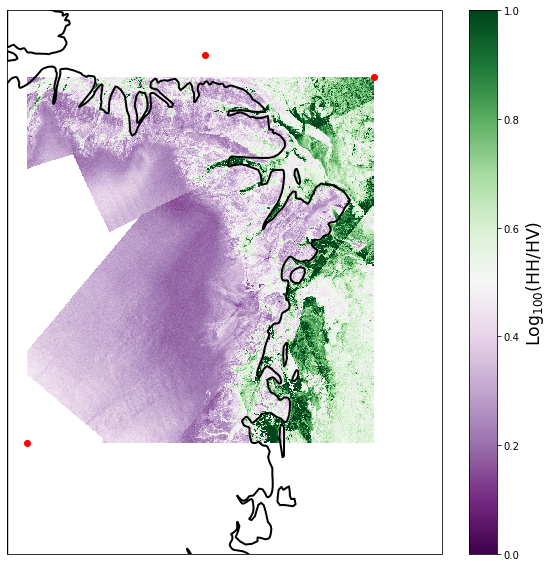

In [25]:
fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection=ccrs.UTM(zone=28))

# This is my bounding box
# [-40, 80, -5, 84]

ax.set_extent([lon0-1, lon1-1, lat1+1, lat0-1], ccrs.PlateCarree())

pm = ax.pcolormesh(lon_degrees, 
               lat_degrees, 
               dtp[:-1,:-1], 
                vmin = 0, 
                vmax = 1,
                transform=ccrs.PlateCarree(),
                cmap='PRGn',
                alpha=1)

ax.scatter([lon0,lon1],[lat0,lat1],transform=ccrs.PlateCarree(),color='r',zorder=2)
ax.scatter([lon0,lon1],[lat1,lat0],transform=ccrs.PlateCarree(),color='r',zorder=2)


ax.add_feature(cartopy.feature.LAND.with_scale('50m'), edgecolor='k',zorder=1,facecolor='None',linewidth=2)

cb = plt.colorbar(pm)

cb.set_label('Log$_{100}$(HH/HV)',fontsize='xx-large')